In [2]:
import nltk
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from Translator import Translator, Translatorv2
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, StepLR
from utils import read_json, train_model, make_wordinddicts, evaluation
from nltk.tokenize import RegexpTokenizer

device = torch.device('cuda')
torch.cuda.empty_cache()

tokenizer = RegexpTokenizer(r'[\w]+|[^\w\s]')

In [3]:
data = read_json('train')
source_word2ind, source_ind2word, target_word2ind, target_ind2word, max_len, dataset = make_wordinddicts(data, tokenizer)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [4]:
model = Translatorv2(len(source_word2ind), len(target_word2ind), 1024, dropout_prob=0.2).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=target_word2ind['<PAD>'])
optimizer = torch.optim.Adam(model.parameters())
lr_scheduler = ReduceLROnPlateau(optimizer, factor=0.5, patience=30)

In [5]:
losses = train_model(model, criterion, optimizer, dataloader, 1)

epoch:1


100%|██████████| 30000/30000 [2:20:34<00:00,  3.56it/s]  


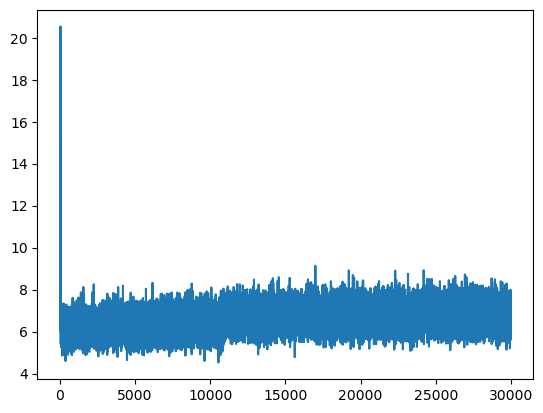

In [6]:
plt.plot(losses)
plt.show()

In [7]:
data = read_json('val')
_, _, _, _, max_len, dataset = make_wordinddicts(data, tokenizer)
source_sentences = dataset.source_samples
target_sentences = dataset.target_samples
evaluation(model, None, max_len, source_sentences, target_sentences, source_word2ind, source_ind2word, target_word2ind, target_ind2word, temperature = 0.2)

100%|██████████| 500/500 [1:30:38<00:00, 10.88s/it]

Average BLEU score: 0.0


In [14]:
from utils import translate_sentence
from tqdm import tqdm
data = read_json('test_no_reference')
# result = []
for line in tqdm(data):
    sentence = [char for char in line['src']]
    translated_sentence = translate_sentence(model, sentence, source_word2ind, source_ind2word, target_word2ind, target_ind2word, max_length=max_len, temperature=0.1)
    print(translated_sentence)
    break
    result.append({'src': line['src'],
                   'dst': ''.join(translated_sentence)})


  0%|          | 0/1000 [00:10<?, ?it/s]

cedric swabbie mongols mut mongols electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting agitating agitating electrocuting agitating electrocuting electrocuting electrocuting agitating electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting agitating agitating agitating agitating electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting electrocuting 83 electrocuting 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 83 tinkle tinkle agitating agitating agitating agitating agitating agitating ando

In [ ]:
result[5]